In [37]:
# The MIT License (MIT) Copyright (c) 2024 Andrés Urbano Andrea, Núñez Quintana Luis Axel & Ramírez Gómez María Emilia
#
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in the Software without
# restriction, including without limitation the rights to use, copy, modify, merge, publish,
# distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all copies or
# substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED,
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND
# NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES
# OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/Andrea585976/ArtEmis-ProyectoPLN/blob/main/models/artemis_transformers_unique.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
</table>

# Image Captioning Transformer


- This notebook explores the combination of Transformers and CNNs for image captioning, showcasing their remarkable ability to generate descriptive textual captions based on visual content.

## 0. Dependencias

In [38]:
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import PIL
from PIL import Image
import random
import time
import torch
from torch import optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
import torchvision
from torchvision import transforms

torch.__version__

'2.3.0+cu121'

In [39]:
torch.manual_seed(77)

## 1.- Dataset

In [40]:
# Download dataset
if not os.path.exists('img'):
  !wget https://github.com/Andrea585976/ArtEmis-ProyectoPLN/raw/main/img.zip
  !unzip img.zip
  !rm img.zip
if not os.path.exists('romanticism_dataset.csv'):
  !wget https://raw.githubusercontent.com/Andrea585976/ArtEmis-ProyectoPLN/main/romanticism_dataset.csv


In [41]:
# Cargar el archivo CSV en un DataFrame de pandas
df = pd.read_csv('romanticism_dataset.csv')
print(df.columns)

images = df.loc[:, ['painting', 'utterance']]
images['painting'] = images['painting'].apply(lambda x: 'img/' + x + '.jpg')

images.head(10)

Index(['painting', 'emotion', 'utterance', 'repetition'], dtype='object')


painting  \
0  img/viktor-vasnetsov_ivan-tsarevich-riding-the...   
1  img/viktor-vasnetsov_ivan-tsarevich-riding-the...   
2            img/william-turner_fishermen-at-sea.jpg   
3            img/william-turner_fishermen-at-sea.jpg   
4              img/paul-cezanne_the-oilmill-1871.jpg   
5  img/n.c.-wyeth_merlin-taking-away-the-infant-a...   
6       img/orest-kiprensky_the-family-of-satyrs.jpg   
7  img/sir-lawrence-alma-tadema_strigils-and-spon...   
8         img/orest-kiprensky_putto-with-a-globe.jpg   
9     img/sir-lawrence-alma-tadema_pleading-1876.jpg   

                                           utterance  
0  The scene is quite beautiful and reminds me of...  
1  There is a sense of romance between the two pe...  
2  There is a spooky feel to this image, with the...  
3  The boat makes a dangerous journey alone at ni...  
4  The village looks very rudimentary with it's s...  
5  It looks like the baby is being taken for what...  
6    The imps playfully dance and sing to the music.  
7  The women appear quite interested in one anoth...  
8  The little boy is trying to roll the globe aro...  
9  The man laying down in this painting feels lik...

- Download images:

In [42]:
# Convertir df_subset en un arreglo NumPy sin nombres de columnas
images = images.values
images = sorted(images, key = lambda x: x[0])
len(images)

39069

- Dataset split

In [43]:
# split is made so that train and val dont have the same painting
num_val_samples = int(0.05 * len(images)) + 2
train_images = images[num_val_samples:]
val_images= images[:num_val_samples]
print(train_images[:1],val_images[-1:])
print(len(train_images), len(val_images))

[array(['img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg',
       'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting'],
      dtype=object)] [array(['img/arthur-hughes_the-beautiful-lady-without-pity-1863.jpg',
       'The look of two people in love.'], dtype=object)]
37114 1955


In [44]:
def generate_tuples(paths):
    tuples = []
    for image_path, text in paths:
        if os.path.exists(image_path):  # Verificar si la imagen existe en la ruta
            tuples.append((image_path, text.strip()))
    return tuples

train_tuples = generate_tuples(train_images)
val_tuples = generate_tuples(val_images)

len(train_tuples), len(val_tuples)

(36910, 1851)

In [45]:
for tuple in train_tuples[:2]:
    print(tuple)

('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'This is interesting because did the maiden find the child and return to the queen or did the queen just deliver while they were on a ride. Very interesting')
('img/arthur-hughes_the-birth-of-tristan-from-the-story-of-tristan-and-isolde.jpg', 'The mother face looks excited to hold her baby for the first time')


## 2.- Pipeline

- Create vocabulary and tokenizer.

In [46]:
tokenizer = get_tokenizer('basic_english')

In [47]:
def build_vocab(text, tokenizer):
    counter = Counter()
    for _, string_ in text:
        counter.update(tokenizer(string_))
    return Vocab(counter, specials=['<unk>', '<pad>', '<bos>', '<eos>'])


vocab = build_vocab(train_tuples, tokenizer)
vocab.set_default_index(0) # fix <ukn>

In [48]:
vocab_size = len(vocab)
vocab_size

16820

In [49]:
image_size = 128
batch_size = 64
maxlen = 36

PAD_IDX = vocab['<pad>']
BOS_IDX = vocab['<bos>']
EOS_IDX = vocab['<eos>']
PAD_IDX, BOS_IDX, EOS_IDX

(1, 2, 3)

* Retrieve a random unique desc for img

In [50]:
#Create dictionaries to retrieve unique random description for each image
train_dict = {}
val_dict = {}

for path, desc in train_tuples:
    if path not in train_dict:
        train_dict[path] = []
    train_dict[path].append(desc)

for path, desc in val_tuples:
    if path not in val_dict:
        val_dict[path] = []
    val_dict[path].append(desc)

In [51]:
def retrieve_random_unique_desc():
  random_train = []
  random_val = []
  for path in train_dict:
      random_train.append((path, random.choice(train_dict[path])))

  for path in val_dict:
      random_val.append((path, random.choice(val_dict[path])))

  return random_train, random_val

In [52]:
random_train, random_val = retrieve_random_unique_desc()

len(train_tuples), len(random_train), len(val_tuples), len(random_val)

(36910, 6507, 1851, 336)

- Reduce dataset size for simplicity

In [53]:
def data_process(text):
    data = []
    for x, y in text:
        tensor_ = torch.tensor(
            [vocab[token] for token in tokenizer(y)],
            dtype=torch.long
        )

        if tensor_.shape[0] < maxlen:
            data.append((x, tensor_))

    return data

random_train, random_val = retrieve_random_unique_desc()

train_data = data_process(random_train)
val_data = data_process(random_val)
len(train_data), len(val_data)

(6272, 327)

In [54]:
transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
])

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        image = Image.open(x_item).convert('RGB')
        image = transform(image)
        x.append(image)
        y.append(
            torch.cat([
                torch.tensor([BOS_IDX]),
                y_item,
                torch.tensor([EOS_IDX])
            ], dim=0)
        )

    x = torch.stack(x)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                    shuffle=False, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

In [55]:
enc_batch, dec_batch, target_batch = next(iter(val_loader))
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 35]), torch.Size([64, 35]))

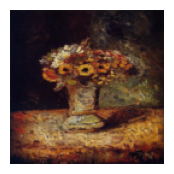

Ground truth: colorful flowers in a vase make me happy .                          


In [56]:
def plot_img(img, target):
    image_array = img.permute(1, 2, 0).numpy()
    image_text = " ".join(
        [vocab.get_itos()[_] for _ in target]
    ).replace("<pad>", "").replace("<eos>", "")

    fig = plt.figure(figsize=(2, 2))

    # Plot the image
    plt.imshow(image_array)
    #plt.title(image_text)
    plt.axis('off')  # Optional: Turn off axes
    plt.show()
    print(f'Ground truth: {image_text}')

idx = 10
plot_img(enc_batch[idx], target_batch[idx])

## 3.- Model

### Feature extraction block
- Define a convolutional network for image feature extraction.

In [57]:
class DownBlockComp(nn.Module):
    def __init__(self, in_planes, out_planes):
        super(DownBlockComp, self).__init__()

        self.main = nn.Sequential(
            nn.Conv2d(in_planes, out_planes, 3, 2, 1, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True),
        )

        self.direct = nn.Sequential(
            nn.AvgPool2d(2, 2),
            nn.Conv2d(in_planes, out_planes, 1, 1, 0, bias=False),
            nn.BatchNorm2d(out_planes), nn.LeakyReLU(0.2, inplace=True))

    def forward(self, feat):
        return (self.main(feat) + self.direct(feat)) / 2

In [58]:
class CNN(nn.Module):
    def __init__(self, filters=128, noise_dim=64):
        super(CNN, self).__init__()
        self.filters = filters
        self.down_block = nn.Sequential(
            nn.Conv2d(3, filters // 8, 3, 1, 1, bias=False),
            nn.BatchNorm2d(filters // 8), nn.LeakyReLU(0.2, inplace=True),
            DownBlockComp(filters // 8, filters // 4),
            DownBlockComp(filters // 4, filters // 2),
            DownBlockComp(filters // 2, filters),
            DownBlockComp(filters, filters),
            nn.Conv2d(filters, filters, 3, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.down_block(x)
        x = torch.permute(x, [0, 2, 3, 1]).view(B, -1, self.filters)
        return x


discriminator = CNN(256)
out_disc = discriminator(enc_batch)
out_disc.shape

torch.Size([64, 36, 256])

### Transformer block

In [59]:
class Attention(nn.Module):
    def __init__(self, dim, maxlen, n_heads=4, bias=True):
        super().__init__()
        self.n_heads = n_heads
        self.scale = (dim // n_heads) ** -0.5
        self.wq = nn.Linear(dim, dim, bias = bias)
        self.wk = nn.Linear(dim, dim, bias = bias)
        self.wv = nn.Linear(dim, dim, bias = bias)

        self.wo = nn.Linear(dim, dim, bias = bias)
        self.register_buffer("bias", torch.tril(torch.ones(maxlen, maxlen)).view(1, 1, maxlen, maxlen))

    def forward(self, x, context=None):
        B, L, D = x.shape
        out_L = L
        q = self.wq(x)
        q = torch.reshape(q, [B, L, self.n_heads, -1])
        q = torch.permute(q, [0, 2, 1, 3])

        if context == None:
            k = self.wk(x)
            v = self.wv(x)
        else:
            k = self.wk(context)
            v = self.wv(context)
            B, L, D = k.shape

        k = torch.reshape(k, [B, L, self.n_heads, -1])
        k = torch.permute(k, [0, 2, 3, 1])
        v = torch.reshape(v, [B, L, self.n_heads, -1])
        v = torch.permute(v, [0, 2, 1, 3])

        qk = torch.matmul(q, k) * self.scale
        if context == None:
            qk = qk.masked_fill(self.bias[:,:,:L,:L] == 0, float('-inf'))

        attn = torch.softmax(qk, dim=-1)

        v_attn = torch.matmul(attn, v)
        v_attn = torch.permute(v_attn, [0, 2, 1, 3])
        v_attn = torch.reshape(v_attn, [B, out_L, D])

        x = self.wo(v_attn)
        return x


q_test = torch.ones([1, 8, 32])
k_test = torch.ones([1, 64, 32])
test_layer = Attention(32, maxlen, n_heads=4)
test_layer(q_test).shape, test_layer(q_test, k_test).shape

(torch.Size([1, 8, 32]), torch.Size([1, 8, 32]))

- Define Transformer:

In [88]:
class DecoderBlock(nn.Module):
    def __init__(self, dim, maxlen, heads=4, mlp_dim=512, rate=0.0):
        super().__init__()
        self.ln_1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, maxlen)
        self.cross_attn = Attention(dim, maxlen)
        self.ln_2 = nn.LayerNorm(dim)
        self.ln_3 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(rate),
            nn.Linear(mlp_dim, dim),
            nn.Dropout(rate),
        )

    def forward(self, x):
        inputs, context = x
        x = self.attn(inputs)
        skip1 = self.ln_1(x + inputs)
        x = self.cross_attn(skip1, context)
        skip2 = self.ln_2(x + skip1)
        return self.ln_3(self.mlp(skip2) + skip2)


test_layer = DecoderBlock(32, maxlen)
x_test = torch.ones([1, maxlen, 32])
test_layer([x_test, x_test]).shape

torch.Size([1, 36, 32])

- Define Transformer

In [89]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 35]), torch.Size([64, 35]))

### Transformer

In [90]:
class Transformer(nn.Module):
    def __init__(self, dim, vocab_size, maxlen, depth=3,
                 mlp_dim=512, rate=0.2):
        super().__init__()
        self.depth = depth
        self.embedding = nn.Embedding(vocab_size, dim)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, maxlen, dim))

        self.decoder = nn.ModuleList()
        for i in range(self.depth):
            self.decoder.append(DecoderBlock(dim, maxlen))

        self.head = nn.Linear(dim, vocab_size, bias=False)
        self.cnn = CNN(dim)

    def forward(self, x, context):
        B, L = x.shape
        x = self.embedding(x)
        x += self.pos_embedding[:, :L]

        context = self.cnn(context)
        for layer in self.decoder:
            x = layer([x, context])
        x = self.head(x)
        return x


model_dim = 64
mlp_dim = 128
depth = 3

transformer = Transformer(dim=model_dim, vocab_size=vocab_size,
          maxlen=maxlen, depth=depth, mlp_dim=mlp_dim)
output = transformer(dec_batch, enc_batch)
output.shape, target_batch.shape

(torch.Size([64, 35, 16820]), torch.Size([64, 35]))

## 4.- Training

In [91]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

transformer.to(device)

cuda:0


Transformer(
  (embedding): Embedding(16820, 64)
  (decoder): ModuleList(
    (0-2): 3 x DecoderBlock(
      (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (cross_attn): Attention(
        (wq): Linear(in_features=64, out_features=64, bias=True)
        (wk): Linear(in_features=64, out_features=64, bias=True)
        (wv): Linear(in_features=64, out_features=64, bias=True)
        (wo): Linear(in_features=64, out_features=64, bias=True)
      )
      (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (ln_3): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=64, out_features=512, bias=True)
        (1): G

In [92]:
optimizer = optim.Adam(transformer.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

In [93]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_dec, inp_enc)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

In [94]:
def generate(model, image, device, maxlen):
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        model.eval()
        idx = torch.tensor(BOS_IDX, dtype=torch.long)
        idx = idx.reshape([1, -1])

        for _ in range(maxlen):
            idx = idx.to(device)
            logits = model(idx, image)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            if vocab.get_itos()[idx_next] == '<eos>':
                break
            idx = torch.cat((idx, idx_next), dim=1)

    txt = " ".join(
        [vocab.get_itos()[_] for _ in idx[0]]
    )
    print(f'Generated text: {txt.replace("<bos>", "")}')

generate(transformer, enc_batch[idx], device, maxlen)

Generated text:  adstract evolved entirely queen situtation sneak sums lover/friend jousting shroud valuable spoils casual fixated lonesome bus steaks leave rooftop wondering meaty eeriness valiant eternal hardworking situtation thrilled heroism cracks akin mid- protect territory members village salvador


In [95]:
def random_data_for_training():
    global train_loader, train_data
    random_train, random_val = retrieve_random_unique_desc()
    train_data = data_process(random_train)
    train_loader = DataLoader(train_data, batch_size=batch_size,
                    shuffle=True, collate_fn=generate_batch,
                    num_workers=4, pin_memory=True)

In [101]:
epochs = 50

for epoch in range(epochs):
    random_data_for_training()
    train(transformer, device, train_loader, optimizer, epoch)
    generate(transformer, enc_batch[idx], device, maxlen)


Time for epoch 0 is 9.6875 sec Train loss: 3.3122
Generated text:  the sun setting over the ocean makes for a peaceful sight .

Time for epoch 1 is 9.4131 sec Train loss: 3.2979
Generated text:  the sun shining down on the water is very relaxing and i love the sunset .

Time for epoch 2 is 10.0640 sec Train loss: 3.3031
Generated text:  the sun is setting in the sunset

Time for epoch 3 is 10.0139 sec Train loss: 3.2746
Generated text:  the sun is setting in the sky , and the orange , and the sun is so bright and the colors are so bright and the colors of the sky is very bright .

Time for epoch 4 is 9.5083 sec Train loss: 3.2596
Generated text:  the sun is setting , the orange and the orange in the background is breathtaking .

Time for epoch 5 is 9.9121 sec Train loss: 3.2543
Generated text:  the sunset in the background makes me feel like i ' m in awe of the sunset .

Time for epoch 6 is 10.0941 sec Train loss: 3.2401
Generated text:  the sun is setting , the orange and the orange 

- Test the model on validation images.

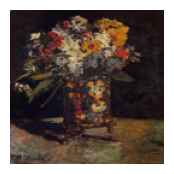

Ground truth: since this is a still life , there isn ' t much conflict , and the flowers look fresh , so it just feels nice .         
Generated text:  the man is wearing a red cape


In [97]:
idx = 4
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

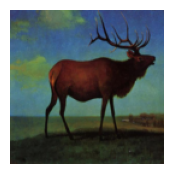

Ground truth: the artist did a very good job of getting all of the details of the animal correct .                 
Generated text:  the sky looks like a storm is coming in the woods .


In [98]:
idx = 52
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

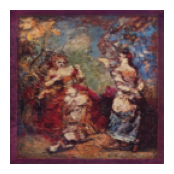

Ground truth: the very expressions given makes it seem like they are having an interesting conversation .                    
Generated text:  the woman is wearing a red crown and the red flowers


In [99]:
idx = 33
plot_img(enc_batch[idx], target_batch[idx])
generate(transformer, enc_batch[idx], device, maxlen)

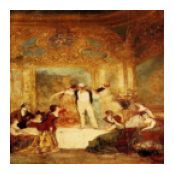

Ground truth: i would love to join this man in revelry . also , very ornate painting .                   
Generated text:  the woman is hunched over the bird hostage and the woman is leaning to make her look vain .


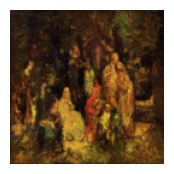

Ground truth: its a nice painting but it doesnt give me any strong feelings one way or another .                  
Generated text:  the people look like they are going to be in a orante conversation


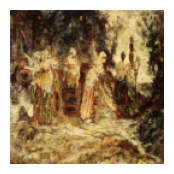

Ground truth: its a little scary with how grainy it is , there is something haunting about it like the scary stories to tell in the dark style artwork .       
Generated text:  the man is wearing a stola and holding a sword


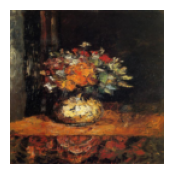

Ground truth: the dark colors reminds me of death and gloom                          
Generated text:  the man is trying to kiss the loss of someone


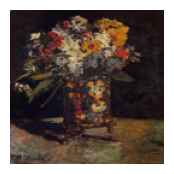

Ground truth: since this is a still life , there isn ' t much conflict , and the flowers look fresh , so it just feels nice .         
Generated text:  the woman is wearing a dress and looks very relaxed


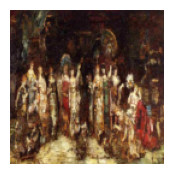

Ground truth: it ' s hard to make out the shapes in this older piece but the color and shadow make it interesting              
Generated text:  the people look like they are going to be in a merry


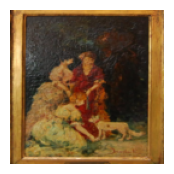

Ground truth: the soft strokes and blurred features make me feel at ease                        
Generated text:  the woman is wearing a dress that is a brilliant shade of red


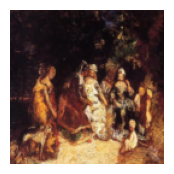

Ground truth: the picture looks blurry                               
Generated text:  the man is trying to stab the woman hostage while the woman is a man is wielding her .


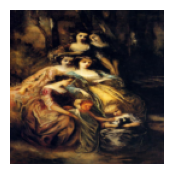

Ground truth: it ' s funny because they ' re all sitting on top of each other                    
Generated text:  the man has a funny look on his face and his face is very disturbing .


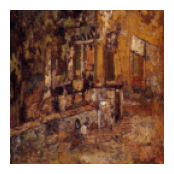

Ground truth: i can ' t really see what is going on so it makes the town look sinister                  
Generated text:  the people look like they are going to be gawking .


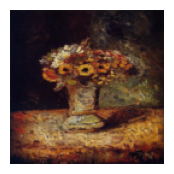

Ground truth: colorful flowers in a vase make me happy .                          
Generated text:  the woman is hunched over the bird hostage and is a bit funny .


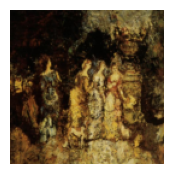

Ground truth: it looks like a terrible event is happening although i ' m not sure what exactly                   
Generated text:  the people look like they are going to be in a romantic tryst


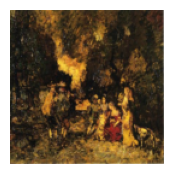

Ground truth: the bright colors of the people and in general really wake me up and make me feel awe .                
Generated text:  the man is hunched over his horse and he is trying to help him


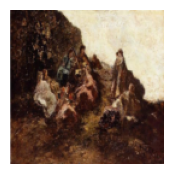

Ground truth: it seems some amusement while they are talking together                          
Generated text:  the man is trying to kill the woman and she is holding her child .


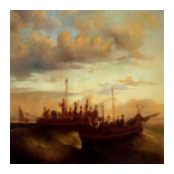

Ground truth: a collection of people in an exposed boat near sundown . the seas a little rough , and hardly anyone is rowing . could this be a lifeboat ?      
Generated text:  the dark colors of the sky and the dark colors of the water make this look like a storm is coming from .


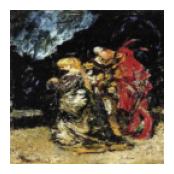

Ground truth: seems like a party is going on .                           
Generated text:  the man is holding a sword into the bed


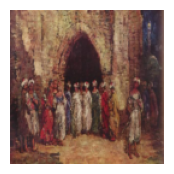

Ground truth: seems like some big <unk> has just occured .                          
Generated text:  the man is holding a sword to the man ' s throne feeding .


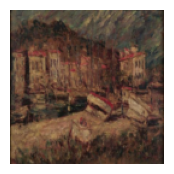

Ground truth: this city brings me feat as it appears broken down and dangerous .                      
Generated text:  the dark colors of the sky and the desperation of the scene is quite mysterious .


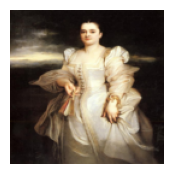

Ground truth: the woman portrayed gives a feeling of someone that is proud to be the person they are so gives a feeling of awe .           
Generated text:  the woman ' s expression is quite lovely and i find her downward gaze quite sad .


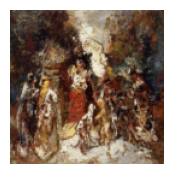

Ground truth: looks <unk> and messy i dont like this one , looks like an imitation of a real painting                 
Generated text:  the people look like they are going to be in a conversation with a weapon .


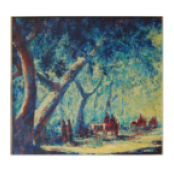

Ground truth: the colors are vibrant and the gathering seems positive .                         
Generated text:  the dark colors of the painting are very depressing .


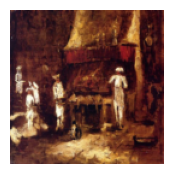

Ground truth: it looks like they are happily working                            
Generated text:  the woman is lying on the ground while the man is holding her is holding her head .


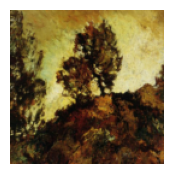

Ground truth: this is a wonderful scene of nature in the fall .                        
Generated text:  the scene is quite lovely in the way the light is pushed of the trees and the woman ' s light


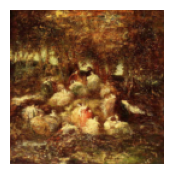

Ground truth: pictures of nature relax me .                             
Generated text:  the woman is lying on the ground while the woman is leaning on .


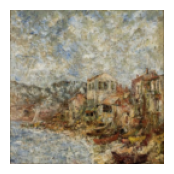

Ground truth: the coloring and the <unk> makes me feel sad .                         
Generated text:  the dark colors of the sky and the stillness of the water is very detailed .


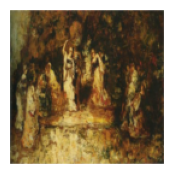

Ground truth: i like the victorian look of the painting . the dolls are beautiful                      
Generated text:  the woman is hunched over in a romantic and revealing flowers


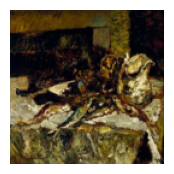

Ground truth: the colors are very dark and the painting looks jagged and aggressive . it looks like an angry painting and that scares me .           
Generated text:  the dark colors of the people are quite lovely and the people look to be in love .


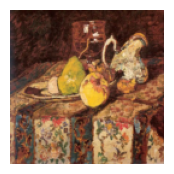

Ground truth: the fruit and drink make we want to eat and drink and i wonder how ' d they taste .               
Generated text:  the woman is wearing a crown of ivy on her head


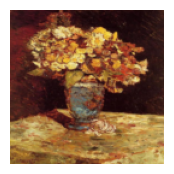

Ground truth: i like the detail in the picture the different colored flowers look nice and i can see the petals on the table .            
Generated text:  the woman is wearing a dress and her hand is playing with her suitor .


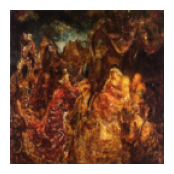

Ground truth: the primary figure appears to be melting into his surroundings                         
Generated text:  the man is hunched over the woman hostage against the window


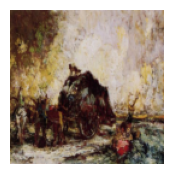

Ground truth: it just feels sad . it looks like a person is stuck in the ground from an earthquake . the expressions feel sad as well          
Generated text:  the people look like they are going to be in a field of sorts .


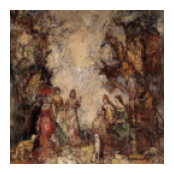

Ground truth: i find this interesting . it ' s got a sketch-like quality , yet also is very painterly .                
Generated text:  the scene is quite lovely in the way the light is depicted .


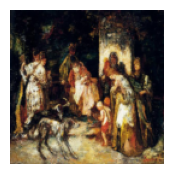

Ground truth: the details and contrast works great in the image .                         
Generated text:  the woman is wearing a dress that is not a good thing


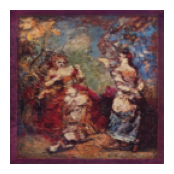

Ground truth: the very expressions given makes it seem like they are having an interesting conversation .                    
Generated text:  the woman is wearing a crown of ivy on her head


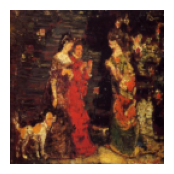

Ground truth: dog in corner looks friendly                              
Generated text:  the woman is wearing a crown of ivy on the floor


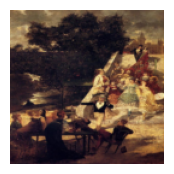

Ground truth: this looks like a vibrant party                             
Generated text:  the man is hunched over the woman hostage against the window


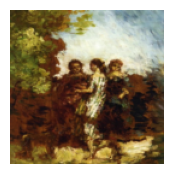

Ground truth: these women are excited to spend time with one another                         
Generated text:  the man is hunched over his horse and he is trying to help him


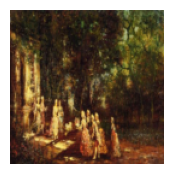

Ground truth: the scene is pretty mundane , but the unique color makes it feel like something horrible is unfolding , like everyone is bathed in blood .         
Generated text:  the people look like they are going to be in a discussion


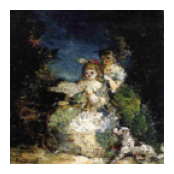

Ground truth: it shows scary faces .                              
Generated text:  the man is wearing a tutu


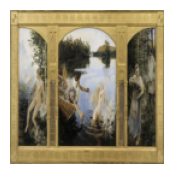

Ground truth: the painting looks so realistic , you can ' t help but stare at it in awe , because it is so beautiful to look at         
Generated text:  the woman is wearing a headband to keep her bangs out of the water


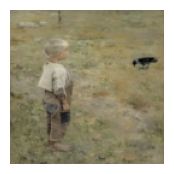

Ground truth: based on how the boy is dressed , he lives in poverty and that ' s saddening                  
Generated text:  the dark colors of the waterfall makes it seem like the sun is setting up the water .


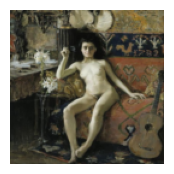

Ground truth: shows the beauty of the women ' s body .                         
Generated text:  the woman is wearing a dress and her hand is so pale and she is leaning .


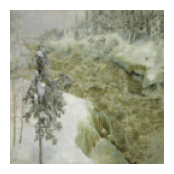

Ground truth: i get an eerie and lonely feeling from this painting . darkness .                      
Generated text:  the woman is lying on the ground while the other person is trying to help her .


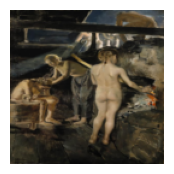

Ground truth: the person <unk> over the other person in the background                         
Generated text:  the people look like they ' re trying to escape the sleeping point of the natives of the horse .


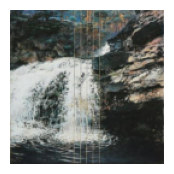

Ground truth: it looks like guitar strings over a waterfall , which is absurd in a funny sort of way                 
Generated text:  the woman ' s eyes are closed and she is not sad to startle .


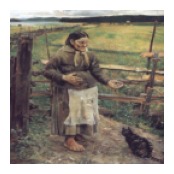

Ground truth: the woman inside this picture looks like she is ill and worked too hard on the farm .                 
Generated text:  the man is wearing a crown of ivy on his head


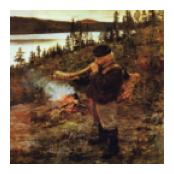

Ground truth: the horn for battle has been sounded . it is peaceful now but will not stay that way .                
Generated text:  the woman is wearing a dress and her hand is wearing a hat


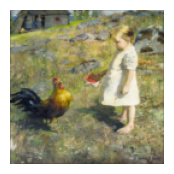

Ground truth: the resolution is low , but it looks like girl and rooster are looking at each other , as if unsure of what the other will do next . i find it amusing . 
Generated text:  the man is holding a sword to a woman


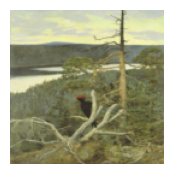

Ground truth: the calm water and natural scenery make me feel serene .                        
Generated text:  the cows are on the beach and the colors are so beautiful


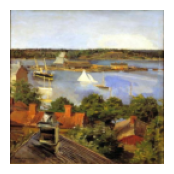

Ground truth: it is a serene outdoor setting , and i like the balance of the reds , greens and blue .               
Generated text:  the cows are quietly grazing on the edge of the docks


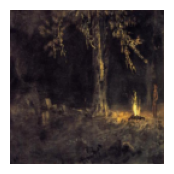

Ground truth: the texture is very dark and gritty , very smoky or foggy which gives it a sense of unknown fears .              
Generated text:  the dark colors and the dark colors make it look like a storm is coming to be fleeing


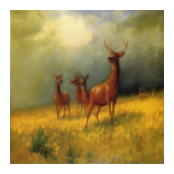

Ground truth: i am always amazed at what god created in these animals                        
Generated text:  the cows are quietly grazing on the beach


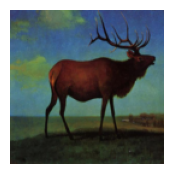

Ground truth: the artist did a very good job of getting all of the details of the animal correct .                 
Generated text:  the dark colors of the sky and the desperation of the painting make me feel awe .


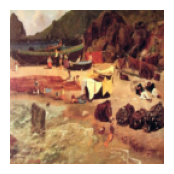

Ground truth: the colors work very well and the tone is very nice to look at .                    
Generated text:  the scene is pastoric and the people are being led their time


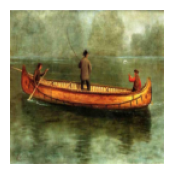

Ground truth: peaceful and optimistic looking scene .                             
Generated text:  the dark colors of the sky and the way the sun hits the side make it seem like a fire


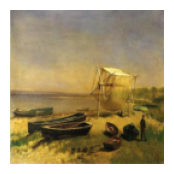

Ground truth: an scene next to the ocean . i love the ocean .                       
Generated text:  the man is about to propose his sword to keep a half-dozen day in the background .


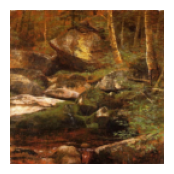

Ground truth: i am in awe . it looks so peaceful and green and full of sunlight and like you want to be a lizard and <unk> up sun on the rocks .    
Generated text:  the woman is hunched over in a romantic and revealing flowers


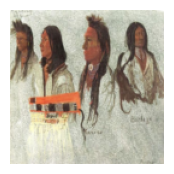

Ground truth: i feel nothing , the <unk> of the background seems out of place compared to the subject , and i lose interest             
Generated text:  the woman is holding the baby


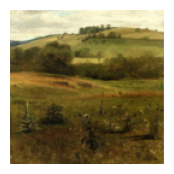

Ground truth: it ' s a serene countryside with nice vegetation .                         
Generated text:  the horse is nibbling on a good tree while tending to the horse


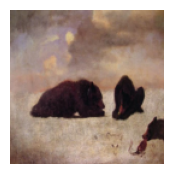

Ground truth: the bears appear to have impressive strength .                           
Generated text:  the man is about to kill the man to the woman


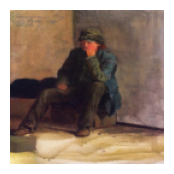

Ground truth: it looks like a person inspired to create something .                         
Generated text:  the man ' s eyes are tied to look like he is about to kill someone .


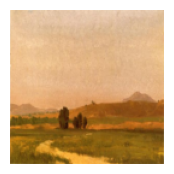

Ground truth: the nature is pretty real                              
Generated text:  the cows are quietly grazing on the beach


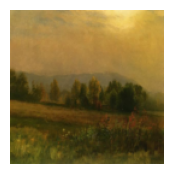

Ground truth: reminds me of a place ive lived at                           
Generated text:  the dark colors of the sky and the dark colors of the land and the people below .


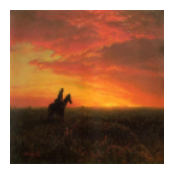

Ground truth: nature is so big and powerful and we are so small                        
Generated text:  the sunset is so beautiful and beautiful , the sunset is so beautiful .


In [102]:
for i in range(64):
  idx = i
  plot_img(enc_batch[idx], target_batch[idx])
  generate(transformer, enc_batch[idx], device, maxlen)